# ANLY-512: HW-3
Author: Dr. Purna Gamage

**Instructions**

* Read and complete all exercises below in the provided `.rmd` notebook 
* [click here to download the notebook for the assignment](HW-3.rmd.zip)

**Submission:**

* You need to upload ONE document to Canvas when you are done. 
* A PDF (or HTML) of the completed form of this notebook
* The final uploaded version should NOT have any code-errors present. 
* All outputs must be visible in the uploaded version, including code-cell outputs, images, graphs, etc

## Import

In [87]:
#knitr::opts_chunk$set(include = FALSE) # for making prompts
knitr::opts_chunk$set(echo = TRUE) # for making solutions
knitr::opts_chunk$set(fig.width = 3)
library(knitr)
library(tidyverse)
library(modeldata)
library(leaps)
library(caret)
library(corrplot)
library(MASS)
library(ISLR)
library(glmnet)
library(gam)



## HW-3.1: Stock returns

Use polynomials and ridge regression to predict stock returns

This problem uses the built in `EuStockMarkets` dataset. The dataset contains time series of closing prices of major European stock indices from 1991 to 1998. We use only the `FTSE` column in this problem. The dataset is a time series object, but you will need to extract the `FTSE` column and make it into a data frame. 

### HW-3.1a: 

Fit polynomial models of degrees 4, 8, 12 to the FTSE data and plot all three fitted curves together with a scatterplot of the data. Comment on the plots. Which features in the data are resolved by the polynomial models? Which features are not resolved? Do the polynomial curves show any artifacts such as oscillations?

In [17]:
# GET DATA
data("EuStockMarkets")
print(head(EuStockMarkets))
ftse <- EuStockMarkets[,4]

         DAX    SMI    CAC   FTSE
[1,] 1628.75 1678.1 1772.8 2443.6
[2,] 1613.63 1688.5 1750.5 2460.2
[3,] 1606.51 1678.6 1718.0 2448.2
[4,] 1621.04 1684.1 1708.1 2470.4
[5,] 1618.16 1686.6 1723.1 2484.7
[6,] 1610.61 1671.6 1714.3 2466.8


In [18]:
print(attributes(ftse))

$tsp
[1] 1991.496 1998.646  260.000

$class
[1] "ts"



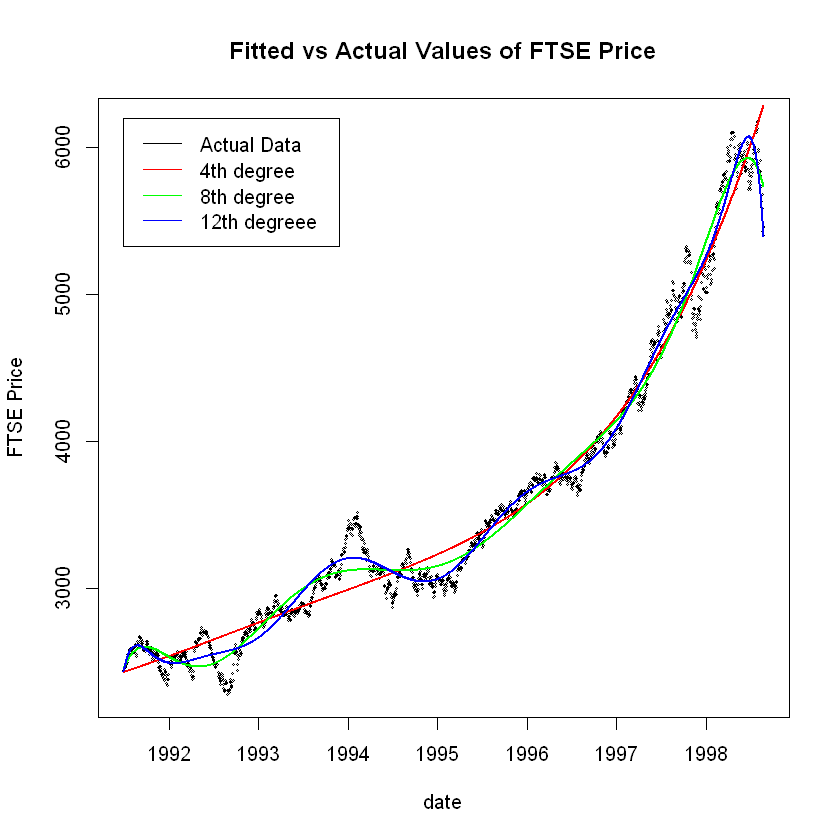

In [19]:
## Converting ftse to a dataframe
FTSE <- data.frame(date = as.numeric(time(EuStockMarkets)), ftse = as.numeric(ftse))
## Fitting polynomial models
poly_4 <- lm(ftse ~ poly(date, 4), data = FTSE)
poly_8 <- lm(ftse ~ poly(date, 8), data = FTSE)
poly_12 <- lm(ftse ~ poly(date, 12), data = FTSE)

## Plotting the fitted curves
plot(FTSE, col = 'black', cex = .3, main = "Fitted vs Actual Values of FTSE Price", ylab = "FTSE Price")
lines(ts(fitted(poly_4), start = 1991.496, frequency = 260), lwd = 2, col = 'red')
lines(ts(fitted(poly_8), start = 1991.496, frequency = 260), lwd = 2,col = 'green')
lines(ts(fitted(poly_12), start = 1991.496, frequency = 260),lwd = 2, col = 'blue')
legend(1991.496,6200,legend=c("Actual Data","4th degree","8th degree", '12th degreee'), col=c("black","red","green", 'blue'),
                    ncol=1, lty =1)

From the plot, we can see that all three polynomial curves capture the overall trend of the FTSE data, with the degree 12 polynomial curve showing the most variation. The curves for the 4th and 8th degree polynomial do not do as well capturing the variations in the data, mostly just tracking the overall trend. However, the polynomial curves do not capture the short-term fluctuations or noise in the data. We can also observe that the degree 12 polynomial curve exhibits some oscillations, which are artifacts of overfitting.

### HW-3.1.b: 
Use ridge regression to regularize the polynomial model of degree 12. Use $\lambda_{1}SE$. Plot the resulting polynomial model onto the the data and comment on it.

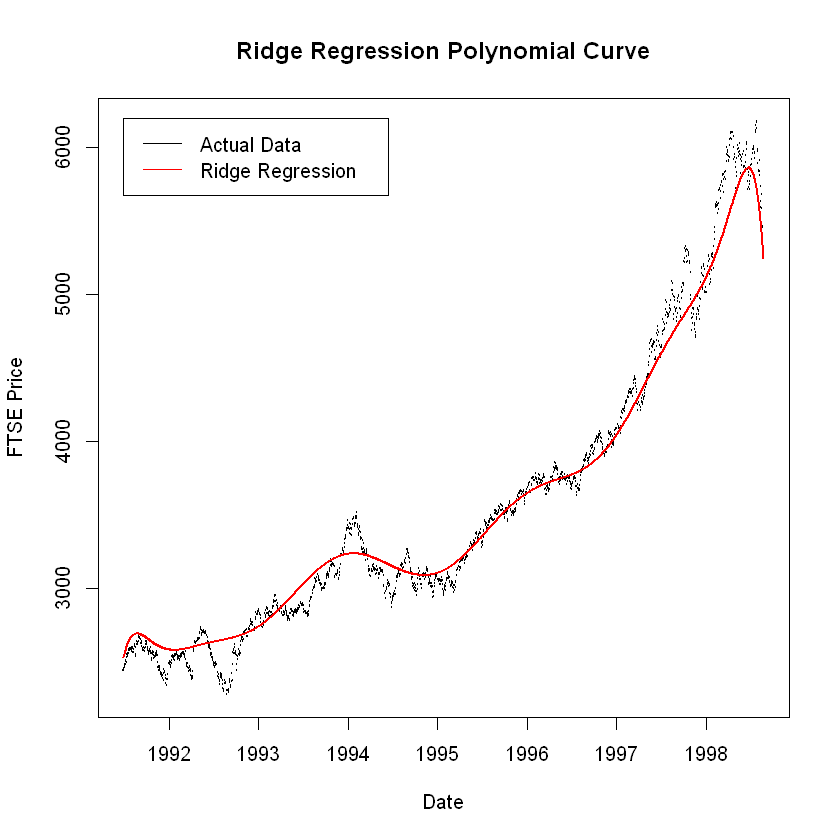

In [20]:
x <- model.matrix(~ poly(date, 12), data = FTSE)
x <- x[,2:ncol(x)]
# fit ridge regression model with cv to choose lambda
fit <- cv.glmnet(x, FTSE$ftse, alpha = 0, lambda.minratio = .00001, nfolds = 10)
best_lambda <- fit$lambda.1se
opt_fit <- glmnet(x, FTSE$ftse, alpha = 0, lambda = best_lambda)

# create sequence of dates for prediction
poly_x <- poly(FTSE$date, 12)
pred_x <- predict(opt_fit, newx = poly_x)

# plot data and predicted curve
plot(FTSE$date, FTSE$ftse, cex = .25, xlab = "Date", ylab = "FTSE Price", main = "Ridge Regression Polynomial Curve")
lines(FTSE$date, pred_x, lwd = 2, col = "red")
legend(1991.496,6200,legend=c("Actual Data",'Ridge Regression'), col=c("black","red"),
                    ncol=1, lty =1)

From the plot, we can see that the predicted polynomial curve from ridge regression captures the overall trend of the FTSE data and is less prone to oscillations compared to the unregularized degree 12 polynomial curve. The regularization penalty has helped to shrink the coefficients of the higher-order terms and reduce the overfitting of the model as we can see below. However, the predicted curve still does not capture the short-term fluctuations or noise in the data.

## HW-3.2: Advertising budgets

Improve advertising budgets using GAMs

Use the Advertising dataset, which can either be found [here]('https://georgetown.instructure.com/files/6146482/download?download_frd=1'). Split the data into a training and test set (70% / 30%).

In [90]:
# GET DATA
set.seed(441)
ads <- read_csv('https://www.statlearning.com/s/Advertising.csv')
ads <- ads[,-1] # remove the X variable (index)
train <- sample(200,140)
train_data <- ads[train,]
test_data <- ads[!1:nrow(ads) %in% train,]
head(ads)

New names:
• `` -> `...1`
Rows: 200 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (5): ...1, TV, radio, newspaper, sales

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


TV,radio,newspaper,sales
<dbl>,<dbl>,<dbl>,<dbl>
230.1,37.8,69.2,22.1
44.5,39.3,45.1,10.4
17.2,45.9,69.3,9.3
151.5,41.3,58.5,18.5
180.8,10.8,58.4,12.9
8.7,48.9,75.0,7.2


### HW-3.2a: 
Fit generalized additive models to predict sales, using smoothing splines of degrees 2, 3, 4, 5, 6 for the three predictors. How do the rms prediction errors compare to the rms prediction error of a multiple regression model on the training set? On the test set?

In [98]:
# Fit GAM with smoothing splines of degrees 2 to 6
model_2 <- gam(sales ~ s(TV, k = 2, bs = "cr") +
               s(radio, k = 2, bs = "cr") +
               s(newspaper, k = 2, bs = "cr"),
             data = train_data)

model_3 <- gam(sales ~ s(TV, k = 3, bs = "cr") +
               s(radio, k = 3, bs = "cr") +
               s(newspaper, k = 3, bs = "cr"),
             data = train_data)

model_4 <- gam(sales ~ s(TV, k = 4, bs = "cr") +
               s(radio, k = 4, bs = "cr") +
               s(newspaper, k = 4, bs = "cr"),
             data = train_data)

model_5 <- gam(sales ~ s(TV, k = 5, bs = "cr") +
               s(radio, k = 5, bs = "cr") +
               s(newspaper, k = 5, bs = "cr"),
             data = train_data)

model_6 <- gam(sales ~ s(TV, k = 6, bs = "cr") +
               s(radio, k = 6, bs = "cr") +
               s(newspaper, k = 6, bs = "cr"),
             data = train_data)

# Make predictions on training set and calculate RMS prediction error
train_pred_2 <- predict(model_2, newdata = train_data)
train_error_2 <- sqrt(mean((train_pred_2 - train_data$sales)^2))
train_pred_3 <- predict(model_3, newdata = train_data)
train_error_3 <- sqrt(mean((train_pred_3 - train_data$sales)^2))
train_pred_4 <- predict(model_4, newdata = train_data)
train_error_4 <- sqrt(mean((train_pred_4 - train_data$sales)^2))
train_pred_5 <- predict(model_5, newdata = train_data)
train_error_5 <- sqrt(mean((train_pred_5 - train_data$sales)^2))
train_pred_6 <- predict(model_6, newdata = train_data)
train_error_6 <- sqrt(mean((train_pred_6 - train_data$sales)^2))

# Make predictions on test set and calculate RMS prediction error
test_pred_2 <- predict(model_2, newdata = test_data)
test_error_2 <- sqrt(mean((test_pred_2 - test_data$sales)^2))
test_pred_3 <- predict(model_3, newdata = test_data)
test_error_3 <- sqrt(mean((test_pred_3 - test_data$sales)^2))
test_pred_4 <- predict(model_4, newdata = test_data)
test_error_4 <- sqrt(mean((test_pred_4 - test_data$sales)^2))
test_pred_5 <- predict(model_5, newdata = test_data)
test_error_5 <- sqrt(mean((test_pred_5 - test_data$sales)^2))
test_pred_6 <- predict(model_6, newdata = test_data)
test_error_6 <- sqrt(mean((test_pred_6 - test_data$sales)^2))

# Fit multiple regression model
reg_model <- lm(sales ~ TV + radio + newspaper, data = train_data)

# Make predictions on training set and calculate RMS prediction error
reg_train_pred <- predict(reg_model, newdata = train_data)
reg_train_error <- sqrt(mean((reg_train_pred - train_data$sales)^2))

# Make predictions on test set and calculate RMS prediction error
reg_test_pred <- predict(reg_model, newdata = test_data)
reg_test_error <- sqrt(mean((reg_test_pred - test_data$sales)^2))

# Print RMS prediction errors
res <- data.frame(model = c('Degree 2 Spline','Degree 3 Spline','Degree 4 Spline','Degree 5 Spline','Degree 6 Spline', 'Multiple Regression'),
                  Train_Error = c(train_error_2,train_error_3,train_error_4,train_error_5,train_error_6, reg_train_error),
                  Test_Error = c(test_error_2,test_error_3,test_error_4,test_error_5,test_error_6,reg_test_error))
res


Warning message in smooth.construct.cr.smooth.spec(object, dk$data, dk$knots):
"basis dimension, k, increased to minimum possible
"
Warning message in smooth.construct.cr.smooth.spec(object, dk$data, dk$knots):
"basis dimension, k, increased to minimum possible
"
Warning message in smooth.construct.cr.smooth.spec(object, dk$data, dk$knots):
"basis dimension, k, increased to minimum possible
"


model,Train_Error,Test_Error
<chr>,<dbl>,<dbl>
Degree 2 Spline,1.365658,1.966276
Degree 3 Spline,1.365658,1.966276
Degree 4 Spline,1.326725,1.831890
Degree 5 Spline,1.296767,1.835503
Degree 6 Spline,1.294932,1.832310
Multiple Regression,1.581650,1.935590


On the train sets, all the GAM models outperformed the multiple regression by a fair margin. On the test set, the degree 4-6 splines outerpformed the multiple regression, but degree 2 and 3 splines performed worse.

### HW-3.2.b: 
Is there evidence of overfitting?

There is evidence of overfitting because there is a large difference between training and test error The training error may continue to decrease as the model complexity increases, but the test error being higher (specifically in the 5th and 6th degree splines) can mean that these complex models do not generalize as well to unseen data. Given the complexity of the higher degree models, thi sis of particular concern. 

We also see that there is a test error plateau after the degree 4 spline. The 5th and 6th degree splines have slightly better train error, but worse test error. Here, I would say that the 5th and 6th degree splines are overfit.

### HW-3.2.c: 
You now have six models (five GAM and one LM). Which model should be used? Explain your answer.

The GAM with the 4th degree smoothing splines should be used. This model sees some of the lowest train error and reports the lowest test error. It also marks the point before the test error begins to rise as we move into an overfitting regime. As a result, this 4th degree spline model appears to be optimal.

## HW-3.3: Boston housing

Use LASSO to predict housing prices in Boston

Consider the `Boston` data from the `MASS` package. We want to use LASSO to predict the median home value `medv` using all the other predictors.

### HW-3.3.a: 
Set up the LASSO and plot the trajectories of all coefficients. What are the last five variables to remain in the model?

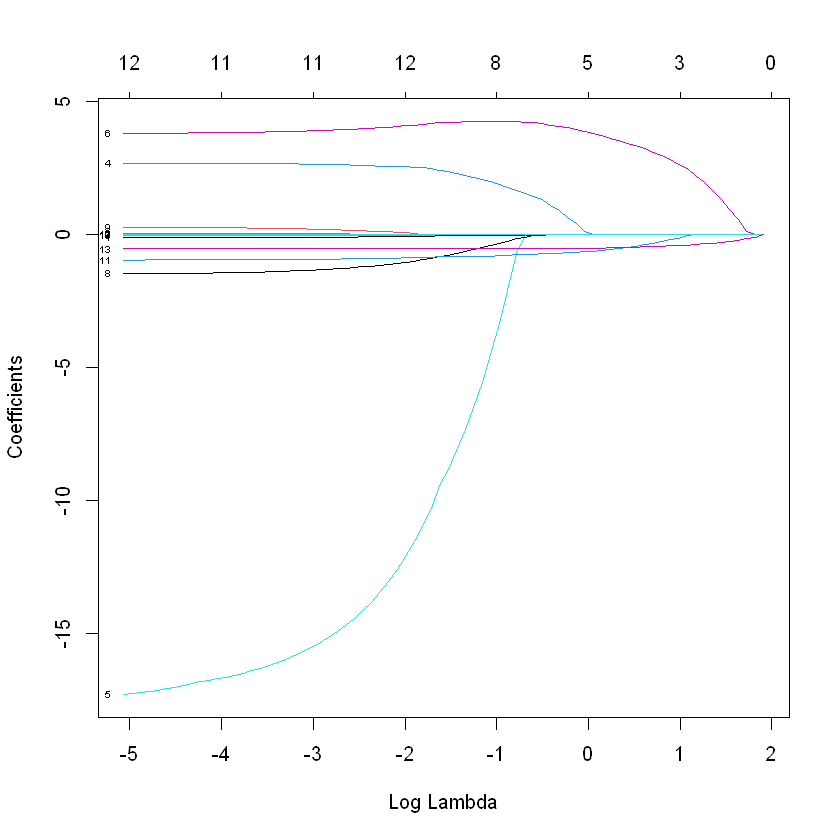

In [22]:
data(Boston)
set.seed(123)

X <- model.matrix(medv ~., data = Boston)[,2:ncol(Boston)]
y  <- Boston[, 'medv']

# Fit LASSO model
lasso_mod <- cv.glmnet(X, y, alpha = 1, nfolds = 10)

# Plot coefficient trajectories
plot(lasso_mod$glmnet.fit, xvar = "lambda", label = TRUE)

In [23]:
# Identify last five variables to remain in the model
lasso_mod_opt <- glmnet(X, y, alpha = 1, lambda = .8)
coef(lasso_mod_opt)

14 x 1 sparse Matrix of class "dgCMatrix"
                      s0
(Intercept) 14.591080859
crim         .          
zn           .          
indus        .          
chas         0.661960730
nox          .          
rm           4.023519352
age          .          
dis          .          
rad          .          
tax          .          
ptratio     -0.668680454
black        0.003612582
lstat       -0.500911909

The last 5 variables in the model are chas (near the Charles River), rm (Avg # of rooms), ptratio (student-teacher ratio), black (proportion of black people), and lstat.

### HW-3.3.b:
Find the 1SE value of $\lambda$, using 10-fold cross-validation. What is the cross validation estimate for the residual standard error?

In [24]:
## Already did 10 fold CV above so get estimate from there
lambda.1se <- lasso_mod$lambda.1se

# compute cross-validation estimate of residual standard error
rse <- lasso_mod$cvm[which(lasso_mod$lambda == lambda.1se)]
cat(paste0("Lambda:",lambda.1se, "\n","RSE: ", rse, "\n"))


Lambda:0.500917541268124
RSE: 28.3814064219382


### HW-3.3.c: 
Rescale all predictors so that their mean is zero and their standard deviation is 1. Then set up the LASSO and plot the trajectories of all coefficients. What are the last five variables to remain in the model? Compare your answer to part a.

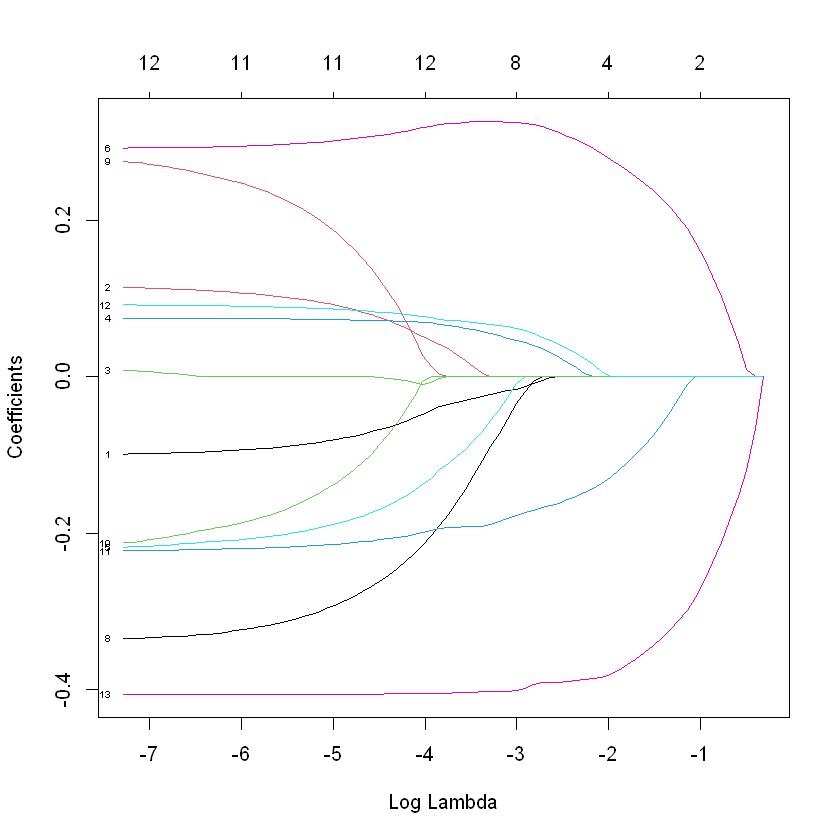

In [25]:
# Fit LASSO model
X_s <- scale(X)
y_s <- scale(y)
lasso_mod_s <- cv.glmnet(X_s, y_s, alpha = 1, nfolds = 10)

# Plot coefficient trajectories
plot(lasso_mod_s$glmnet.fit, xvar = "lambda", label = TRUE)

In [26]:
# Identify last five variables to remain in the model
lasso_mod_opt <- glmnet(X_s, y_s, alpha = 1, lambda = .09)
coef(lasso_mod_opt)

14 x 1 sparse Matrix of class "dgCMatrix"
                       s0
(Intercept) -1.718716e-16
crim         .           
zn           .           
indus        .           
chas         1.576664e-02
nox          .           
rm           3.055947e-01
age          .           
dis          .           
rad          .           
tax          .           
ptratio     -1.558143e-01
black        3.354449e-02
lstat       -3.885851e-01

The last 5 variables are the same here and in part A indicating agreement that these variables are the crucial ones for determining median home value.

### HW-3.3.d: 
Find the 1SE value of $\lambda$ using 10-fold cross-validation. What is the cross validation estimate for the residual standard error now? Does rescaling lead to a better performing model?

In [27]:
## Already did 10 fold CV above so get estimate from there
lambda.1se_s <- lasso_mod_s$lambda.1se

# compute cross-validation estimate of residual standard error
rse <- lasso_mod_s$cvm[which(lasso_mod_s$lambda == lambda.1se_s)]
cat(paste0("Lambda:",lambda.1se, "\n","RSE: ", rse, "\n"))

Lambda:0.500917541268124
RSE: 0.305067548626136


Rescaling leads to a significantly lower lambda and RMSE, however it is difficult to compare model performance between these 2 because the rescaled values are all between -3 and 3 with a mean of 0 whereas the previous values were between 5 and 50 with a mean of 22. To do this better we should look at the correlation between the predictions and actual values. 

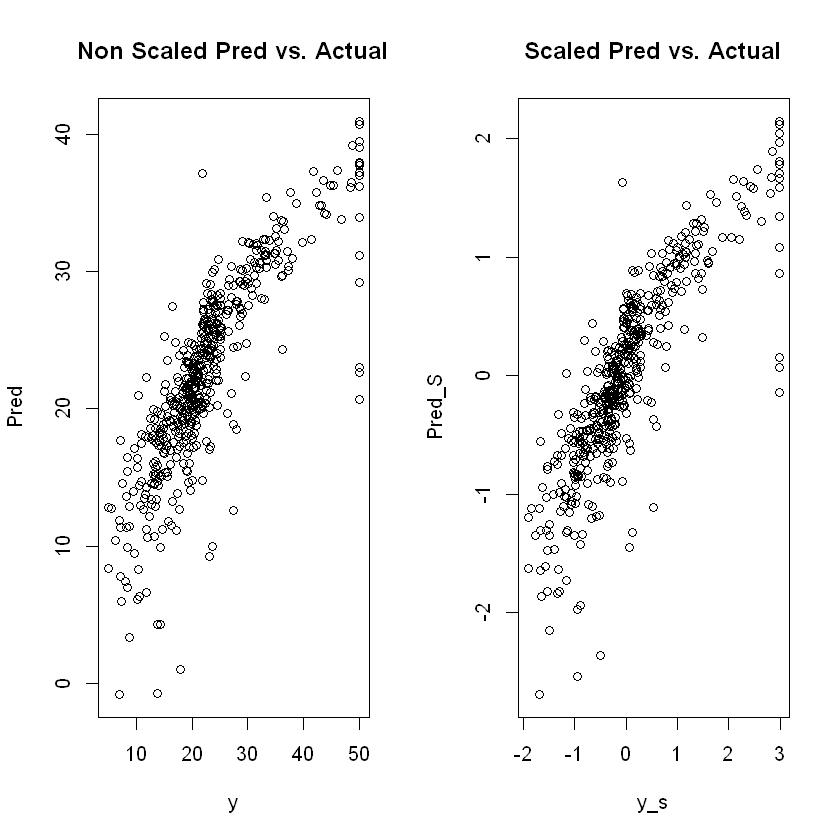

In [28]:
par(mfrow = c(1,2))
plot(y, predict(lasso_mod, newx = X, lambda = lambda.1se), main = "Non Scaled Pred vs. Actual", ylab = "Pred")
plot(y_s, predict(lasso_mod_s, newx = X_s, lambda = lambda.1se_s), main = "Scaled Pred vs. Actual", ylab = "Pred_S")

Given the plots we can say that the models perform equally well, but the scaling does fit our predicted range into a smaller value range which can be helpful for data consistency across models.

## HW-3.4: Bike share usage

Predict bike share usage in Seoul using ridge and LASSO regressions

Access the [dataset here](https://archive.ics.uci.edu/ml/machine-learning-databases/00560/SeoulBikeData.csv). Filter the data to only include rows with "`functioning days`" == 'Yes'. Next drop the columns `Date`, `Hour`, `Seasons`, and `Holiday`, and `Functioning Day`. Then drop any rows that have any missing values in any columns. Hint: You will need to rename some of the variable names because they include non-ASCII characters. This will help you later on.

In [1]:
# GET DATA

bike <- read.csv('data/SeoulBikedata.csv')
head(bike)

,Date,Rented.Bike.Count,Hour,Temperature..C.,Humidity...,Wind.speed..m.s.,Visibility..10m.,Dew.point.temperature..C.,Solar.Radiation..MJ.m2.,Rainfall.mm.,Snowfall..cm.,Seasons,Holiday,Functioning.Day
,<chr>,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0,0,0,Winter,No Holiday,Yes
2,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0,0,0,Winter,No Holiday,Yes
3,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0,0,0,Winter,No Holiday,Yes
4,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0,0,0,Winter,No Holiday,Yes
5,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0,0,0,Winter,No Holiday,Yes
6,01/12/2017,100,5,-6.4,37,1.5,2000,-18.7,0,0,0,Winter,No Holiday,Yes


In [4]:
## Filter to only functioning days and drop specified columns
bike <- 
    bike %>%
    filter(Functioning.Day == "Yes") %>%
    subset(., select = -c(Date, Hour, Seasons, Holiday, Functioning.Day))
head(bike)

,Rented.Bike.Count,Temperature..C.,Humidity...,Wind.speed..m.s.,Visibility..10m.,Dew.point.temperature..C.,Solar.Radiation..MJ.m2.,Rainfall.mm.,Snowfall..cm.
,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,254,-5.2,37,2.2,2000,-17.6,0,0,0
2,204,-5.5,38,0.8,2000,-17.6,0,0,0
3,173,-6.0,39,1.0,2000,-17.7,0,0,0
4,107,-6.2,40,0.9,2000,-17.6,0,0,0
5,78,-6.0,36,2.3,2000,-18.6,0,0,0
6,100,-6.4,37,1.5,2000,-18.7,0,0,0


### HW-3.4.a: 

Run a linear regression to predict rented bike count using the remaining 8 variables in the dataset. Report the MSE and the most influential variables.

In [5]:
## Running Linear Regression
## Split into train and test
indexes <- sample(1:nrow(bike), size = floor(nrow(bike) * .8))
train_bike <- bike[indexes,]
test_bike <- bike[!1:nrow(bike) %in% indexes, ]
linear_mod <- lm(Rented.Bike.Count ~ ., data = train_bike)
summary(linear_mod)

## Getting the MSE
pred <- predict(linear_mod, newx = test_bike)
mse <- mean((test_bike$Rented.Bike.Count - pred)**2)
paste("MSE:", mse)


Call:
lm(formula = Rented.Bike.Count ~ ., data = train_bike)

Residuals:
    Min      1Q  Median      3Q     Max 
-1392.3  -296.5   -57.7   204.8  2335.8 

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)    
(Intercept)                8.776e+02  1.170e+02   7.502 7.08e-14 ***
Temperature..C.            3.574e+01  4.586e+00   7.792 7.58e-15 ***
Humidity...               -1.092e+01  1.303e+00  -8.381  < 2e-16 ***
Wind.speed..m.s.           5.193e+01  6.213e+00   8.359  < 2e-16 ***
Visibility..10m.           2.971e-03  1.217e-02   0.244  0.80717    
Dew.point.temperature..C.  9.560e-01  4.841e+00   0.197  0.84347    
Solar.Radiation..MJ.m2.   -1.159e+02  9.608e+00 -12.065  < 2e-16 ***
Rainfall.mm.              -5.181e+01  5.476e+00  -9.461  < 2e-16 ***
Snowfall..cm.              3.775e+01  1.418e+01   2.663  0.00777 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 487 on 6763 degrees of freedom
Multiple R-squa

[1] "MSE: 588471.275608821"

The most influential variables are Temperature, Humidity, Wind Speed, Solar Radiation, Rainfall, and Snowfall. The coefficients make sense in that warmer and less humid and rainy days would see more bike riders. We also see that solar radiation negatively influences the number of rented bikes.

### HW-3.4.b: 

Fit a ridge regression model with the optimal $\lambda$ chosen by cross validation. Report the CV MSE.

In [6]:
## Making the model matrix
X <- model.matrix(Rented.Bike.Count ~., data = bike)[,2:ncol(bike)]
y <- bike$Rented.Bike.Count

## Fitting the cv ridge regression
ridge_mod <- cv.glmnet(X, y, alpha = 0, nfolds = 10)

##Optimal lambda 
opt_lambda <- ridge_mod$lambda.1se

## Fitting the optimal model
opt_ridge_mod <- glmnet(X, y, alpha = 0, lambda = opt_lambda)
coef(opt_ridge_mod)

paste("CV MSE:", ridge_mod$cvm[which(ridge_mod$lambda == opt_lambda)])

9 x 1 sparse Matrix of class "dgCMatrix"
                                    s0
(Intercept)               825.21056019
Temperature..C.            20.82179919
Humidity...                -9.15202807
Wind.speed..m.s.           46.25712034
Visibility..10m.            0.05518653
Dew.point.temperature..C.  10.22003866
Solar.Radiation..MJ.m2.   -38.20738511
Rainfall.mm.              -50.36691600
Snowfall..cm.               1.53634309

[1] "CV MSE: 239351.270353133"

Here the higher magnitude coefficient values were shrunk a bit, and it did make a meaningful difference, cutting the MSE in more than half.

### HW-3.4.c: 
Perform the same fit using a LASSO regression this time. Choose the optimal $\lambda$ using cross validation. Report on the remaining variables in the model and the CV MSE. How does this performance compare to ridge and a plain linear model?

In [8]:
## Fitting the cv lasso regression
lasso_mod <- cv.glmnet(X, y, alpha = 1, nfolds = 10)

##Optimal lambda 
opt_lambda <- lasso_mod$lambda.1se

## Fitting the optimal model
opt_ridge_mod <- glmnet(X, y, alpha = 0, lambda = opt_lambda)
coef(opt_ridge_mod)

paste("CV MSE:", lasso_mod$cvm[which(lasso_mod$lambda == opt_lambda)])

9 x 1 sparse Matrix of class "dgCMatrix"
                                  s0
(Intercept)               990.828129
Temperature..C.            25.300926
Humidity...               -11.806368
Wind.speed..m.s.           51.778842
Visibility..10m.            0.020184
Dew.point.temperature..C.   9.957258
Solar.Radiation..MJ.m2.   -88.391801
Rainfall.mm.              -52.009557
Snowfall..cm.              26.776054

[1] "CV MSE: 239552.171672287"

None of the variables were fully eliminated by the lasso regression, although all of the coefficients were somewhat adjusted. The largest coefficients remain temperature, wind speed, solar radiation, and rainfall just like ridge and regular linear regression reported. With regard to accuracy, ridge regression did the best closely followed by lasso, and both well outperformed regular linear regression. The main commanalities that lead to the outperformance appear to be deemphasizing temperature, solar radiation, and snowfall.

### HW-3.4.e: 
Interpretation and communication. Write a short paragraph about your analysis and recommendations, explaining the most important factors for high bike share usage, why you came to that conclusion, and what actions can be taken by a bike rental company based on this information.

High bike share usage is largely determined by temperature, humidity, wind, and precipitation like rain and snow. Given the clear directionality and high magnitude of the coefficients in the regression, we can say that people are smart and have particular tastes about when they ride bikes. They rent 25 more bikes on average per degree Celsius warmer it is, doing more bike riding the more they want to be outside. We see a slight negative effect for humidity possibly indicating people prefer to minimize sweat potential and/or don't want to deal with slick seats, and we see a large negative effect based on rainfall for safety reasons. We also see that wind speeds lead to an increase in biking - indicating that when people know their hair is getting messed up, they might as well get wherever they are going faster. At first, it seemed that solar radiation might have a meaningful negative effect, but instead it actually has a very minimal effect, costing 88 bikes per radiation unit increase where the max unit is around 3. This means that only on the sunniest of sunny days will we see a real tail off in demand.

Given this insight, I would suggest that bike rental companies look into focusing their bike supply in areas with consistently steady weather (minimizing storms as much as possible), allowing for less rainy days that sap bike riding demand. I would also suggest looking into some form of seat optimization technology to mitigate water on the seat surface - this will help mitigate the negative effects brought on by precipitation and humidity.



## HW-3.5: Splines

Compare the characteristics of two different smoothing splines

Consider two curves called $\hat{g}_1$ and $\hat{g}_2$ are as follows:

$$
\hat{g}_1 = argmin_g \left(\sum_{i=1}^n (y_i - g(x_i))^2 + \lambda \int [g^{(3)}(x)]^2 \right)
$$

$$
\hat{g}_2 = argmin_g \left(\sum_{i=1}^n (y_i - g(x_i))^2 + \lambda \int [g^{(4)}(x)]^2 \right)
$$
where $g^{(m)}$ represents the $m^{th}$ derivative of $g$.


### HW-3.5.a: 
As $\lambda \to \infty$, which function ($\hat{g_1}$ or $\hat{g_2}$) will have the smaller training RSS?

<br>
$\hat{g}_1$ will have a smaller training RSS because as $\lambda \to \infty$, the penalty term in both $\hat{g}_1$ and $\hat{g}_2$ becomes the main focus. The penalty term penalizes higher order derivatives of the function $g$ and creates increasingly smooth fits of the data. Since $\hat{g}_2$ has a penalty on the fourth derivative of $g$, it will be smoother compared to $\hat{g}_1$, which only has a penalty on the third derivative. Therefore, as $\lambda$ increases, $\hat{g}_2$ will be more likely to underfit the data, due to a smoother fit, compared to $\hat{g}_1$, resulting in a larger training RSS for $\hat{g}_2$.


<br>

### HW-3.5.b: 
As $\lambda \to \infty$, which function ($\hat{g_1}$ or $\hat{g_2}$) will have the smaller test RSS?

<br>

The test RSS depends on the generalization ability of the model, which cannot be determined solely based on the value of $\lambda$. In general, a larger value of $\lambda$ can lead to better generalization performance by reducing overfitting. However, the optimal value of $\lambda$ for each model can vary depending on the dataset. Therefore, we cannot determine which function will have a smaller test RSS without actually fitting the models on the test data. 

Given this however, I would expect the $\hat{g}_1$ to have the smaller test RSS for the same reasons it will have the smaller training RSS, it is slightly less smooth and can capture more variation.

<br>

### HW-3.5.c: 
For $\lambda = 0$, which function ($\hat{g_1}$ or $\hat{g_2}$) will have the smaller training and test RSS?

<br>

They will both have the same RSS because when $\lambda = 0$, the penalty term becomes zero, and the two smoothing splines reduce to the OLS regression solution. Therefore, both $\hat{g}_1$ and $\hat{g}_2$ will have the same training and test RSS, and they will be equivalent to the OLS solution.

<br>

## HW-3.6: 

Explain the behavior of the curve for a variety of $\lambda$ and $m$ values.

Suppose a curve $\hat{g}$ is fit smoothly to a set of $n$ points as follows:

$$
\hat{g} = argmin_g \left(\sum_{i=1}^n (y_i - g(x_i))^2 + \lambda \int [g^{(m)}(x)]^2 \right)
$$

where $g^{(m)}$ is the $m$th derivative of $\hat{g}$ and $g^{(0)}=g$. Provide plots of $\hat{g}$ in each of the following scenarios along with the original points provided.

Use the following starter code to make your set of points and plot your various model predictions.

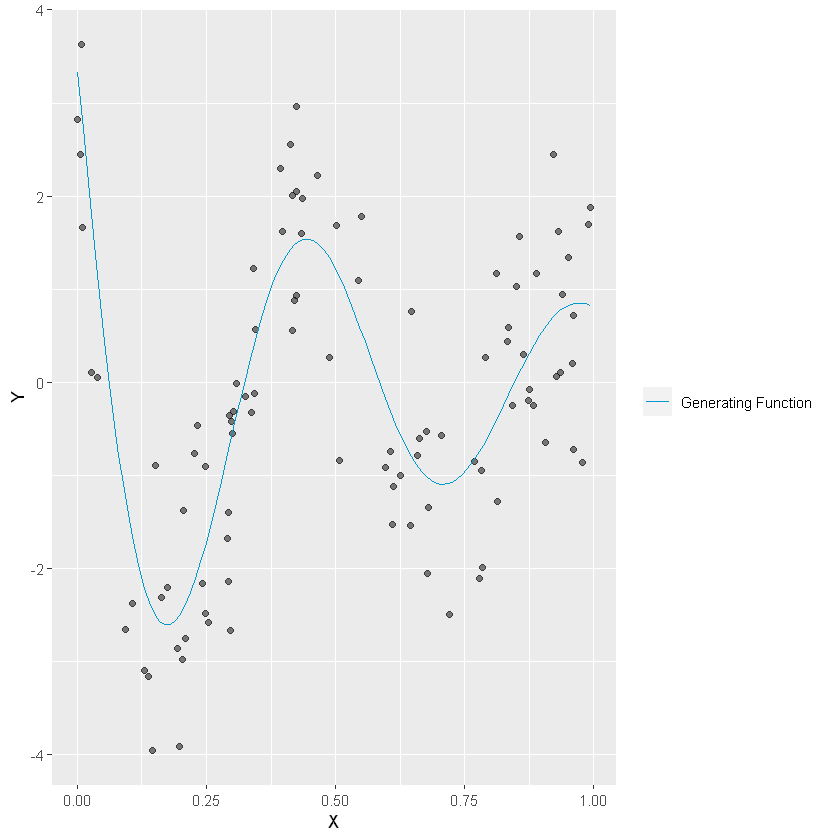

In [3]:
set.seed(325626)

X <- runif(100)
eps <- rnorm(100)
Y <- sin(12*(X + 0.2)) / (X + 0.2) + eps
generating_fn <- function(X) {sin(12*(X + 0.2)) / (X + 0.2)}
df <- data.frame(X, Y)

ggplot(df, aes(x = X, y = Y)) + 
  geom_point(alpha = 0.5) + 
  stat_function(fun = generating_fn, aes(col = "Generating Function")) + 
  scale_color_manual(values = "deepskyblue3") + 
  theme(legend.position = "right", legend.title = element_blank())

### HW-3.6.a: 
$\lambda = \infty, m = 0$.

ERROR: Error in pspline::smooth.Pspline(df$X, df$Y, norder = 0, spar = 10): Wrong value for NORDER


### HW-3.6.b: 
$\lambda = \infty, m = 1$.

In [64]:
fit <- smooth.Pspline(df$X, df$Y, order = 1, spar = Inf)


# Plot the data and the estimated function
ggplot(df, aes(x = X, y = Y)) + 
  geom_point(alpha = 0.5) + 
  stat_function(fun = generating_fn, aes(col = "Generating Function")) + 
  geom_line(aes(y = predict(fit, df$X)$y, col = "Spline")) +
  scale_color_manual(values = c("deepskyblue3", "red")) + 
  theme(legend.position = "right", legend.title = element_blank()) 

ERROR: Error in smooth.Pspline(df$X, df$Y, order = 1, spar = Inf): unused argument (order = 1)


### HW-3.6.c: 
$\lambda = \infty, m = 2$.

In [27]:
# INSERT SOLUTION HERE 

### HW-3.6.d: 
$\lambda = \infty, m = 3$.

In [28]:
# INSERT SOLUTION HERE 

### HW-3.6.e: 
$\lambda = 0, m = 3$.

In [29]:
# INSERT SOLUTION HERE 

### HW-3.6.f: 
Fit a smoothing spline on the dataset and report the optimal lambda

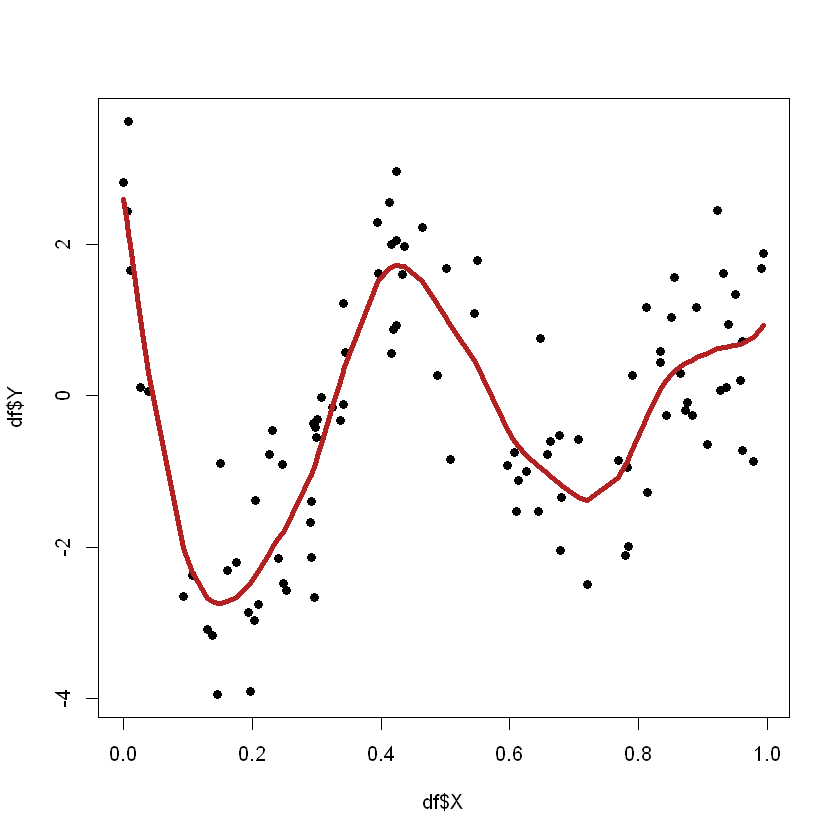

In [82]:
plot(df$X, df$Y, pch=19)
ss_fit <- smooth.spline(df$X,df$Y,cv=TRUE) 
lines(ss_fit,col="firebrick", lwd=4)

In [83]:
ss_fit

Call:
smooth.spline(x = df$X, y = df$Y, cv = TRUE)

Smoothing Parameter  spar= 0.747396  lambda= 0.0001052001 (12 iterations)
Equivalent Degrees of Freedom (Df): 11.67057
Penalized Criterion (RSS): 72.26631
PRESS(l.o.o. CV): 0.9373877

The optimal lambda according to CV is 0.000105 indicating that we need a very flexible and wiggly spline to fit this data.